In [1]:
# never mind adding some import statements at the start of the notebook
from pyspark.sql.functions import isnan, when, count, col, to_date, lit
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import date_format
from pyspark.sql.types import StructType, StructField, DoubleType
import datetime
from pyspark.sql.functions import expr
import os
import matplotlib.pyplot as plt
from pyspark.sql.functions import year, month, concat_ws

In [2]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/26 16:22:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Following block of code takes the raw weather data. Preprocesses it and saves it as curated weather data

In [3]:
sdf1 = spark.read.parquet('../data/weather/weather_data.parquet')
sdf1.printSchema()
sdf1.show(1, vertical=True, truncate=100)
# check if there are any null values
missing_values = sdf1.agg(*[F.sum(F.when(F.col(c).isNull(), 1).otherwise(0))
                          .alias(c) for c in sdf1.columns])

# cast date column to date type
sdf1 = sdf1.withColumn("DATE", col("DATE").cast("date"))

# also drop the PGTM column as it is not useful as all values are null
sdf1 = sdf1.drop('PGTM')

# also as per industry practice convert to consistent casing
consistent_casing = [F.col(col_name).alias(col_name.lower())
                    for col_name in sdf1.columns]
sdf1 = sdf1.select(*consistent_casing)
sdf1.printSchema()
sdf1.show(1, vertical=True, truncate=100)

# use better column names for better readability
sdf1 = sdf1.withColumnRenamed('awnd', 'avg_wind_speed') \
            .withColumnRenamed('tavg', 'avg_temp') \
            .withColumnRenamed('tmax', 'max_temp') \
            .withColumnRenamed('tmin', 'min_temp') \
            .withColumnRenamed('prcp', 'precipitation') \
            .withColumnRenamed('snow', 'snowfall')

# create directory for raw weather data and store it there
if not os.path.exists('../data/weather_curated/'):
    os.mkdir('../data/weather_curated/')

# now write this file and if any other present overwrite it
sdf1.write.parquet('../data/weather_curated/weather_data.parquet',\
                 mode ='overwrite')

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- AWND: double (nullable = true)
 |-- PGTM: double (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- SNOW: double (nullable = true)
 |-- TAVG: double (nullable = true)
 |-- TMAX: double (nullable = true)
 |-- TMIN: double (nullable = true)



-RECORD 0-----------------------------------
 STATION | USW00094789                      
 NAME    | JFK INTERNATIONAL AIRPORT, NY US 
 DATE    | 2022-01-01                       
 AWND    | 2.8                              
 PGTM    | null                             
 PRCP    | 31.0                             
 SNOW    | 0.0                              
 TAVG    | 10.1                             
 TMAX    | 11.7                             
 TMIN    | 8.9                              
only showing top 1 row

root
 |-- station: string (nullable = true)
 |-- name: string (nullable = true)
 |-- date: date (nullable = true)
 |-- awnd: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- tmin: double (nullable = true)

-RECORD 0-----------------------------------
 station | USW00094789                      
 name    | JFK INTERNATIONAL AIRPORT, NY US 
 date    | 2022

## Lets begin some preprocessing on yellow taxi data

In [4]:
# lets begin by seeing whether we have same data types for all months
sdf = spark.read.parquet('../data/tlc/')
sdf_jan = spark.read.parquet('../data/tlc/2022-01.parquet')
sdf_jan.printSchema()
sdf_feb_23 = spark.read.parquet('../data/tlc/2023-02.parquet')
sdf_feb_23.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetim

## In output for above cell we see that some columns have different data types such as VendorID and passenger_count. First lets cast all data to Jan 2022 schema as it has passenger_count as double. So we can remove any counts that are not whole numbers

In [5]:
def cast_to_schema(year, start, end, temp_schema):
    """ This function takes in the year, start and end month and the schema
    and casts the columns to the data type and saves it to the data/raw/
    directory. `year` is a string, `start` and `end` are integers months and
    `temp_schema` is a spark schema.
    This function is specific for the TLC data to store data to raw layer.
    """
    
    for month in range(start, end+1):
        input_path = f'../data/tlc/{year}-{str(month).zfill(2)}.parquet'
        output_path = f'../data/raw/{year}-{str(month).zfill(2)}.parquet'
        sdf_malformed = spark.read.parquet(input_path)
        sdf_malformed = sdf_malformed \
                        .select([F.col(c).cast(temp_schema[i].dataType)\
                        for i, c in enumerate(sdf_malformed.columns)])
        sdf_malformed.coalesce(1).write.mode('overwrite').parquet(output_path)

In [6]:
# see if there is any non-whole number passenger_count. So it can be removed
# before any proper data conversion can be made. Lets cast all data to 
# jan 2022 schema which contains passenger_count as "double"
tem_schema = sdf_jan.schema
tem_schema
cast_to_schema("2022", 1, 12, tem_schema)
cast_to_schema("2023", 1, 5, tem_schema)

In [7]:
# see if there is any non-whole number passenger_count
sdf = spark.read.parquet('../data/raw/*')
non_whole_count = sdf.filter(col("passenger_count") % 1 != 0).count()
print(f"Number of rows with non-whole number passenger : {non_whole_count}")

Number of rows with non-whole number passenger : 0


## Ok now we are sure there isn't any non-whole number passenger_count. So, lets cast all data now to Feb 2023 schema which is more closer to the yellow taxi data dictionary

In [8]:
# lets  cast all datatype to 2023 february schema (proper schema)
sdf_feb_23.printSchema()

# also ensuring we have consistent casing for all columns
consistent_col_casing = [F.col(col_name).alias(col_name.lower())\
                        for col_name in sdf_feb_23.columns]
sdf_feb_23 = sdf_feb_23.select(*consistent_col_casing)
sdf_schema = sdf_feb_23.schema
sdf_schema

cast_to_schema(2022, 1, 12, sdf_schema)
cast_to_schema(2023, 1, 5, sdf_schema)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [9]:
# read raw data to verify
sdf = spark.read.parquet('../data/raw/*')
sdf.printSchema()
sdf.show(1, vertical=True, truncate=100)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

-RECORD 0------------------------------------
 VendorID              | 1                   
 tpep_pickup_datetime  | 2022-10-

## Done with raw data &#128512;

In [10]:
# according to data dictionary store_and_fwd_flag represents boolean condition
# but currently have N and Y to represent No and Yes respectively
sdf = sdf.withColumn('store_and_fwd_flag', 
    (F.col('store_and_fwd_flag') == 'Y').cast('boolean'))
sdf.show(1, vertical=True, truncate = 100)

-RECORD 0------------------------------------
 VendorID              | 1                   
 tpep_pickup_datetime  | 2022-10-01 00:03:41 
 tpep_dropoff_datetime | 2022-10-01 00:18:39 
 passenger_count       | 1                   
 trip_distance         | 1.7                 
 RatecodeID            | 1                   
 store_and_fwd_flag    | false               
 PULocationID          | 249                 
 DOLocationID          | 107                 
 payment_type          | 1                   
 fare_amount           | 9.5                 
 extra                 | 3.0                 
 mta_tax               | 0.5                 
 tip_amount            | 2.65                
 tolls_amount          | 0.0                 
 improvement_surcharge | 0.3                 
 total_amount          | 15.95               
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row



In [11]:
# lets see the datashape before doing any further preprocessing
tot_rows = sdf.count()
tot_cols = len(sdf.columns)
print("Total rows: ", tot_rows, "Total columns: ", tot_cols)

Total rows:  55842484 Total columns:  19


## lets see we dont have any months in our data that were affected by covid

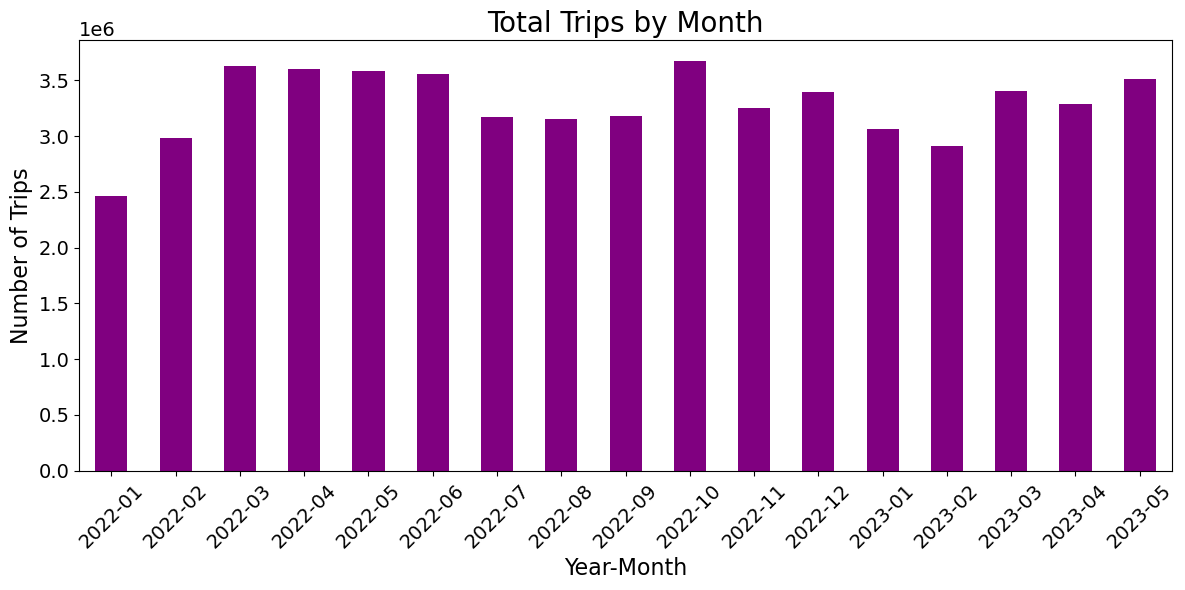

In [12]:
# lets draw the bar chart to see whether our data contains any month affected
# by covid

# Extract the year and month from the tpep_pickup_datetime column
sdf_monthly = sdf.withColumn("year", year("tpep_pickup_datetime")) \
                              .withColumn("month", month("tpep_pickup_datetime"))

# Aggregate data by year and month
monthly_counts = sdf_monthly.groupBy("year", "month") \
                            .count() \
                            .orderBy("year", "month") \
                            .withColumn("year_month", 
                                        concat_ws("-", col("year"), 
                                                  F.lpad(col("month"), 2, '0'))) \
                            .toPandas()
# Plot
axis = monthly_counts \
       .set_index("year_month")["count"] \
       .plot(kind='bar', color='purple', legend=None, figsize=(12,6))

# Set x-ticks for 2022-01 to 2023-05
all_ticks = monthly_counts["year_month"].tolist()
selected_ticks = [f"{year}-{str(month).zfill(2)}" for year in [2022, 2023] \
                  for month in range(1, 13) if not (year == 2023 and month > 5)]
tick_positions = [all_ticks.index(tick) for tick in selected_ticks]
plt.xticks(tick_positions, selected_ticks, rotation=45)

# Adjust xlim to not cut off bars
first_position = tick_positions[0] - 0.5
last_position = tick_positions[-1] + 0.5

plt.xlim(first_position, last_position)

plt.title("Total Trips by Month", fontsize=20)
plt.xlabel("Year-Month", fontsize=16)
plt.ylabel("Number of Trips", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axis.yaxis.offsetText.set_fontsize(14)
plt.tight_layout()

# Save plot
plt.savefig('../plots/trips_by_all_months.png')
plt.show()

In [13]:
# ok we see that 2022-01 is clearly affected as it has lowest count
# than any other lets remove jan-2022 data from further analysis
sdf_filtered = sdf.filter(~((year(col("tpep_pickup_datetime")) == 2022) \
                            & (month(col("tpep_pickup_datetime")) == 1)))
sdf = sdf_filtered

# lets see the datashape again
tot_rows = sdf.count()
tot_cols = len(sdf.columns)
print("Total rows: ", tot_rows, "Total columns: ", tot_cols)

Total rows:  53378584 Total columns:  19


## Need to handle missing data now

In [14]:
# lets see which columns have missing values
missing_values = sdf.agg(*[F.sum(F.when(F.col(c).isNull(), 1)\
                        .otherwise(0)).alias(c) for c in sdf.columns])
missing_values.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|        1725465|            0|   1725465|           1725465|           0|           0|           0|          0|    0|      0|         

In [15]:
# well there is immense amount of missing passenger_count data. 
# (imputation doesn't makes sense here) so let drop those (1796968) rows
missing_passenger = (missing_values.collect()[0]['passenger_count'] 
                    / tot_rows * 100)
print(f'percentage of missing passenger_count data: {missing_passenger}%')

sdf_clean = sdf.filter(col("passenger_count").isNotNull())
missing_values2 = sdf_clean.agg(*[F.sum(F.when(F.col(c).isNull(), 1)\
                            .otherwise(0)).alias(c) for c in sdf_clean.columns])
missing_values2.show()

percentage of missing passenger_count data: 3.2325042567633493%


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

`after removing misssing passenger_count no other values seems to be missing` \
`How nice is this dataset? No missing values at all.`
## lets start doing some outlier detection


In [16]:
# Add a new temporary column to record trip distance so can remove those
# trips whcih span more than 5 hours (as per google maps we can cover whole
# NYC in 3 hours)
sdf_with_difference = sdf_clean.withColumn("time_difference", 
                                          col("tpep_dropoff_datetime")
                                          - col("tpep_pickup_datetime"))

# Count rows where the time_difference is more than 5 hours and remove them
count_greater_than_5_hours = sdf_with_difference \
                             .filter(expr("time_difference "
                             "> interval 5 hours")).count()

print(f"Number of rows with time_difference greater than 5 hours: "
      f"{count_greater_than_5_hours}, percentage: " 
      f"{count_greater_than_5_hours/sdf_with_difference.count() * 100}%")

# remove those rows where time_difference is more than 5 hours                                      
sdf_clean2 = sdf_with_difference \
            .filter(expr("time_difference <= interval 5 hours"))
# no further need of time_difference column
sdf_clean2 = sdf_clean2.drop("time_difference")

# count rows that records drop off time before pick up time
invalid_dropoff = sdf_clean2.filter(expr("tpep_dropoff_datetime"
                                    " <= tpep_pickup_datetime")).count()

print(f"Number of rows with invalid drop off time: {invalid_dropoff}," 
      f" percentage: {invalid_dropoff/sdf_clean2.count() * 100}%")

# now remove rows that records drop off time before pick up time
sdf_clean2 = sdf_clean2.filter(expr("tpep_dropoff_datetime"
                                    " > tpep_pickup_datetime"))

Number of rows with time_difference greater than 5 hours: 60073, percentage: 0.11630081815582134%


Number of rows with invalid drop off time: 22290, percentage: 0.04320349684335366%


In [17]:
# reomove Trips with a pick-up/drop-off location ID out of the range 1-263
# because only these are valid zones for NYC
sdf_clean3 = sdf_clean2.filter(expr("PULocationID >= 1 "
                                    "AND PULocationID <= 263 "
                                    "AND DOLocationID >= 1 "
                                    "AND DOLocationID <= 263"))

invalid_id = sdf_clean2.count() - sdf_clean3.count()
print(f"Number of invalid location IDs: {invalid_id}",
      f"percentage: {invalid_id/sdf_clean2.count()*100}%")
print(sdf_clean3.count())

Number of invalid location IDs: 907496 percentage: 1.7597104839804947%


50663260


In [18]:
# remove rows with passenger count 0 or less as it is invalid imputation donot
# make sense
sdf_clean4 = sdf_clean3.filter(expr("passenger_count > 0"))
data_count = sdf_clean3.count()
invalid_passenger_count = data_count - sdf_clean4.count()
print(f"invalid passenger count: {invalid_passenger_count}"
      f" percentage: {invalid_passenger_count/data_count*100}%")

invalid passenger count: 968512 percentage: 1.9116653764483376%


In [19]:
# remove rows with trip_distance 0 or less
sdf_clean5 = sdf_clean4.filter(expr("trip_distance > 0"))
data_count = sdf_clean4.count()
invalid_trip_dis = data_count - sdf_clean5.count()
print(f"Number of invalid trip_distance records: {invalid_trip_dis}"
      f" percentage: {invalid_trip_dis/data_count*100}%")

Number of invalid trip_distance records: 554525 percentage: 1.115862384491818%


In [20]:
# see if other outliers present according to data dictionary
print(sdf_clean5.filter(expr('VendorID > 2 AND vendorID < 1')).count())
print(sdf_clean5.filter(expr('RateCodeID > 6 AND RateCodeID < 1')).count())
print(sdf_clean5.filter(expr('payment_type > 6 AND payment_type < 1')).count())
print(sdf_clean5.filter(expr("improvement_surcharge < 0 OR fare_amount < 0"
                            " OR extra < 0 OR mta_tax < 0 or tip_amount < 0"
                            " OR total_amount < 0 OR congestion_surcharge < 0"
                            " OR airport_fee < 0 OR tip_amount < 0"
                            " OR tolls_amount < 0")).count())

0
0
0


322390


In [21]:
# so we have some outliers in above cell lets remove those
sdf_clean6 = sdf_clean5.filter(expr(" improvement_surcharge >= 0"
                                    " AND fare_amount >= 0 AND extra >= 0"
                                    " AND mta_tax >= 0 AND tip_amount >= 0"
                                    " AND total_amount >= 0"
                                    " AND congestion_surcharge >= 0"
                                    " AND airport_fee >= 0 AND tip_amount >= 0"
                                    " AND tolls_amount >= 0"))
prev = sdf_clean5.count()
removed = prev - sdf_clean6.count()
print(f"rows removed {removed} "
      f"percentage: {removed/prev*100}%")

rows removed 322390 percentage: 0.6560613288222156%


In [22]:
# also we might have some wrong date recorded in the data, we should remove them
from pyspark.sql.functions import col, to_date, lit, date_format


sdf_clean7 = sdf_clean6 \
            .filter((date_format(col("tpep_pickup_datetime"), 'yyyy-MM-dd') \
                        >= lit('2022-02-01')) \
                    & (date_format(col("tpep_pickup_datetime"), 'yyyy-MM-dd') \
                        <= lit('2023-05-31')) \
                    & (date_format(col("tpep_dropoff_datetime"), 'yyyy-MM-dd') \
                        >= lit('2022-02-01')) \
                    & (date_format(col("tpep_dropoff_datetime"), 'yyyy-MM-dd') \
                        <= lit('2023-05-31')))

prev = sdf_clean6.count()
removed = prev - sdf_clean7.count()
print(f"rows removed {removed} "
      f"percentage: {removed/prev*100}%")

rows removed 1126 percentage: 0.002306534171641744%


In [23]:
# lets see how much percentage of data is removed
prev = sdf.count()
removed = prev - sdf_clean7.count()
print("data left after preprocessing: ", sdf_clean7.count())
print("percentage of data removed: ", removed/prev*100)


data left after preprocessing:  48816707
percentage of data removed:  8.54626829366624


## PHEWWW! Done with all yellow taxi data preprocessing
## and outlier detection &#128512;

In [24]:
# now store data in curated layer
sdf_clean7.write.parquet('../data/curated/yellow_taxi.parquet',\
                        mode ='overwrite')